In [2]:
import pandas as pd

df = pd.read_csv('StudentsPerformance.csv')

for cname, series in df.iloc[:,:-3].items():
    print(cname, series.unique())


gender ['female' 'male']
race/ethnicity ['group B' 'group C' 'group A' 'group D' 'group E']
parental level of education ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
lunch ['standard' 'free/reduced']
test preparation course ['none' 'completed']


Mthod pd.get_dummies() could be used instead however dictionary mapping was chosen to keep interpretation easy, 'group A' in race/ethnicity column has been not included to avoid full collinearity (dummy variable trap)

In [3]:

df['group B'] = (df['race/ethnicity'] == 'group B').astype(int)
df['group C'] = (df['race/ethnicity'] == 'group C').astype(int)
df['group D'] = (df['race/ethnicity'] == 'group D').astype(int)
df['group E'] = (df['race/ethnicity'] == 'group E').astype(int)

levels_of_education = {
    'some high school': 1, 
    'high school': 2,
    'some college': 3,
    "associate's degree": 4,
    "bachelor's degree": 5,
    "master's degree": 6,
}
df['parental_level_coded']=df['parental level of education'].map(levels_of_education)

genders = {
    'female': 0,
    'male': 1
}
df['gender_binary'] = df['gender'].map(genders)

lunches = {
    'standard': 1,
    'free/reduced': 0
}
df['lunch_binary'] = df['lunch'].map(lunches)

preparations = {
    'completed': 1,
    'none': 0
}
df['preparation_binary'] = df['test preparation course'].map(preparations)

dataset = df[['group B', 'group C', 'group D', 'group E', 'parental_level_coded', 'gender_binary', 'lunch_binary', 'preparation_binary']].copy()
dataset['avg_score'] = df[['math score', 'writing score', 'reading score']].mean(axis = 1)

print(dataset.head())

   group B  group C  group D  group E  parental_level_coded  gender_binary  \
0        1        0        0        0                     5              0   
1        0        1        0        0                     3              0   
2        1        0        0        0                     6              0   
3        0        0        0        0                     4              1   
4        0        1        0        0                     3              1   

   lunch_binary  preparation_binary  avg_score  
0             1                   0  72.666667  
1             1                   1  82.333333  
2             1                   0  92.666667  
3             0                   0  49.333333  
4             1                   0  76.333333  


<Axes: >

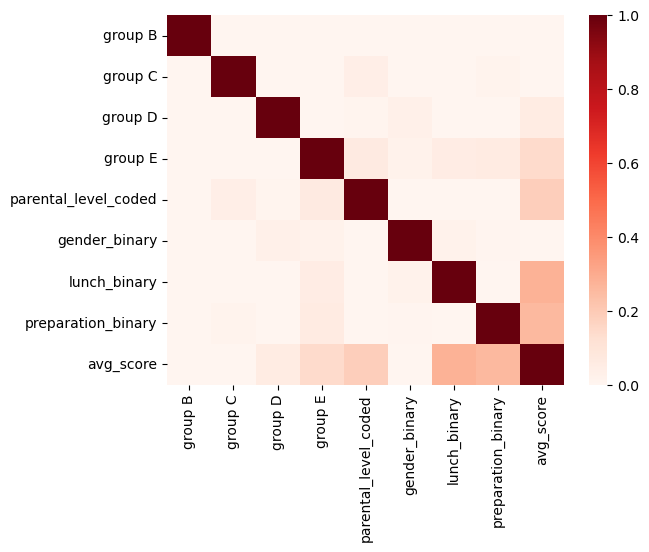

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
corrmat = dataset.corr(method = 'spearman') #pearson not possible due to variables' characters
sns.heatmap(corrmat, vmin = 0, cmap = 'Reds')

Estimating linear regression model using OLS

In [106]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

X = dataset.iloc[:,:-1]
Y = dataset.iloc[:,-1]
X = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

model = sm.OLS(y_train, X_train)
result = model.fit()
print(result.summary())

pred_y_lr = result.predict(X_test)

                            OLS Regression Results                            
Dep. Variable:              avg_score   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     32.50
Date:                Wed, 10 Dec 2025   Prob (F-statistic):           2.48e-44
Time:                        20:31:54   Log-Likelihood:                -3139.7
No. Observations:                 800   AIC:                             6297.
Df Residuals:                     791   BIC:                             6340.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   54.5838 

CatBoost model implementation

In [68]:
from catboost import CatBoostRegressor

#reading fresh data
df_temp = pd.read_csv('StudentsPerformance.csv')
y = df_temp[['math score', 'reading score', 'writing score']].mean(axis=1) 
X = df_temp.iloc[:, :-3]

X_train_ct, X_test_ct, y_train_ct, y_test_ct = train_test_split(X, y, test_size = 0.2, random_state = 42)

#categorical columns
cat_features = X.columns.to_list()


# setting hyperparameters 

# with our small dataset (1000 samples) it is needed to prevent model from overfitting.
# To this end, small number of trees' depth and learning rate along with early stopping of algorithm have been implemented

model = CatBoostRegressor(
    iterations = 1000,
    learning_rate = 0.03,
    depth = 6, 
    loss_function = 'RMSE',
    eval_metric='MAE',
    random_seed=42,
    verbose=100, 
    early_stopping_rounds=50
)


model.fit(
    X_train_ct, y_train_ct, 
    cat_features = cat_features, 
    eval_set = (X_test_ct, y_test_ct), 
    use_best_model = True
)

0:	learn: 11.2344513	test: 11.5889138	best: 11.5889138 (0)	total: 15.9ms	remaining: 15.9s
100:	learn: 9.5729760	test: 10.5182321	best: 10.5182321 (100)	total: 1.49s	remaining: 13.3s
200:	learn: 9.2132276	test: 10.4811414	best: 10.4773548 (198)	total: 2.9s	remaining: 11.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 10.47735482
bestIteration = 198

Shrink model to first 199 iterations.


In [ ]:
#feature importance

In [107]:
import shap

Models comparision

In [69]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def stat(real, pred):
    return (r2_score(real, pred), mean_squared_error(real, pred), mean_absolute_percentage_error(real, pred), mean_absolute_error(real, pred))

pred_y_ct = model.predict(X_test_ct)

comparision = pd.DataFrame({
    'OLS': stat(y_test, pred_y_lr),
    'CB': stat(y_test_ct, pred_y_ct),
},
index = ['R2', 'MSE', 'MAPE', 'MAE']
)
print(comparision.round(2))

         OLS      CB
R2      0.18    0.16
MSE   176.31  179.17
MAPE    0.21    0.21
MAE    10.39   10.48


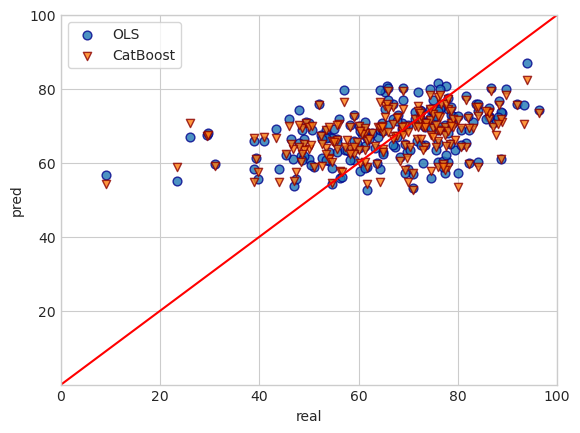

In [105]:
with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.xlim(0, 100)  
    plt.ylim(0, 100)  
    plt.scatter(y_test, pred_y_lr, s = 40, alpha = 0.8, label = 'OLS', edgecolors = 'darkblue')
    plt.scatter(y_test_ct, pred_y_ct, s = 35, alpha = 0.8, marker = 'v', label = 'CatBoost', edgecolors = 'darkred')
    plt.plot([0, 102], [0, 102], c = 'r')
    plt.xlabel('real')
    plt.ylabel('pred')
    plt.yticks(np.arange(20, 101, 20))
    plt.legend(frameon = True)